# Univariate linear

Now that we have our linear expression 

$$
y = \beta_0 + \sum_{i = 1} \beta_i X_i;
$$

we can attempt to find the values for each $\beta$.

Instead of trying to find all parameters simultaneously, we will start with `Social_Media` and call this $X_1$.
This makes our expression

$$
y = \beta_0 + \beta_1 x_1.
$$

Let's explore different ways to get $\beta_0$ and $\beta_1$.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p style="padding-top: 1em">
        You may notice that we are switching between lower and uppercase variables like $X$ and $x$.
        This is standard notation for linear algebra where an uppercase variable, $X$, is an array (i.e., matrix) and a lowercase variable, $x$, is a scalar (i.e., single value).
    </p>
</div>

## Google Sheets

You probably have experience with regression in the domain of Excel or Google Sheets&mdash;called curve fitting.
I made [and example](https://docs.google.com/spreadsheets/d/1BvsIj_HgAcCK348GSRJRdYBtpR0HE37tAi-MfmI0Tu0/edit?usp=sharing) of regression on Google Sheets.
After adding a trend line, we get $\beta_0 = 5932$ and $\beta_1 = 2.42$; keep these values in mind as we proceed.
You will eventually see how similar they are; only how we interact with the computer changes.

## DataFrame

As we do in most exercises, we have to load our dataset into a pandas DataFrame.

In [1]:
import pandas as pd

# Specify where to find our CSV file.
CSV_PATH = "https://gitlab.com/oasci/courses/pitt/biosc1540-2024s/-/raw/main/biosc1540/files/csv/advertising-data.csv"

# Load a print the DataFrame
df_adv = pd.read_csv(CSV_PATH)
print(df_adv)

         TV  Billboards  Google_Ads  Social_Media  Influencer_Marketing  \
0    281.42      538.80      123.94        349.30                242.77   
1    702.97      296.53      558.13        180.55                781.06   
2    313.14      295.94      642.96        505.71                438.91   
3    898.52       61.27      548.73        240.93                278.96   
4    766.52      550.72      651.91        666.33                396.33   
..      ...         ...         ...           ...                   ...   
395  873.32      234.67      563.21        401.88                789.44   
396  421.88      449.22      564.77        334.88                689.77   
397  599.22      789.88      831.32        450.88                398.44   
398  784.33      500.67      958.88        635.22                786.44   
399  290.67      321.88      640.56        765.22                409.77   

     Affiliate_Marketing  Product_Sold  
0                 910.10        7164.0  
1                

A pandas DataFrame is mostly just an interface to our actual data stored in NumPy arrays.
Most scientific Python packages require the data presented to them in this format.
Although, some allow you to pass a DataFrame into a function or method; it will just automate getting the NumPy arrays for you.

In our case, let's manually get our relevant data into NumPy arrays.
Pandas has a method called [`to_numpy()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_numpy.html) that takes one or multiple Series and converts the values to a NumPy array.
Since we are only working with `Social_Media` and `Product_Sold`, we need to slice, convert to an array, and then store this into variables.

In [2]:
import numpy as np

cost_social_media = df_adv["Social_Media"].to_numpy()
product_sold = df_adv["Product_Sold"].to_numpy()

Let's make sure this worked correctly by printing the shape and the first `10` elements.

In [3]:
print(cost_social_media.shape)
print(cost_social_media[:10])

(400,)
[349.3  180.55 505.71 240.93 666.33 142.96 271.62  97.85 759.04 329.15]


In [4]:
print(product_sold.shape)
print(product_sold[:10])

(400,)
[7164. 5055. 6154. 5480. 9669. 7627. 5177. 3726. 9801. 8652.]


Great!
We that we have our data, we can start fitting functions.

## SciPy

[SciPy](https://scipy.org/) is an open-source library in Python used for scientific and technical computing.
It builds on the capabilities of [NumPy](https://numpy.org/).
It provides additional modules for optimization, signal and image processing, statistical functions, linear algebra, integration, interpolation, and more.
Physics, engineering, biology, and data science all widely use SciPy.

SciPy can handle the vast majority of analyses you would want.
It offers an excellent conceptual foundation about what is going on in high-level packages like [sklearn](#sklearn) that we will primarily use in the course.

### Model

The first step for regression is defining the equation or model to fit our data to.
In our case, we defined this above as 

$$
y = \beta_0 + \beta_1 x_1.
$$

You may be wondering how, or even why, we are using this model.
Especially when you are not being told which model to use.
The answer is that you can usually never know *a priori* (i.e., before looking at the data) what model to use.
In real-world problems, most of it is by mathematical intuition where, based on prior knowledge or work, we expect the relationship to behave a certain way.
You can also look at the data like we did previously to check for similarities between known mathematical representations.

In order to optimize an equation in Python, we have to define a function that takes in inputs then computes and return the outputs.
This is just like defining an equation in Google Sheets: `= $B$0 + $B$1 + $A1` would perform our computation for us using cell references to the parameters in column `B` and input in column `A`.
In Python, the only difference is that we need to give it a name and follow it's unique syntax.

The `linear_model` function, defined in the upcoming code block, represents a generic linear expression with parameters `betas` and inputs `x`.

In [5]:
def linear_model(betas, x):
    """Generic linear expression. We will use generic `x` and `y` to show that
    this is generalized to any linear problem.

    Args:
        betas (Iterable[float]): A collection of parameters we can change;
            for example, `[beta_0, beta_1]`.
        x (float or np.ndarray[float]): The independent variable; in this case,
            this should contain `social_media`.

    Returns:
        The dependent variable; in this case, `product_sold`.
    """
    beta_0, beta_1 = betas  # unpack the list
    y = beta_0 + beta_1 * x  # compute the linear expression
    return y

The `linear_model` function takes two parameters: `betas` and `x`.

-   `betas`: This parameter is a sequence (e.g., list or array) containing the coefficients of the linear model.
    In a simple linear regression model, `betas` typically have two elements, representing the intercept (`beta_0`) and the slope (`beta_1`).
- `x`: This parameter represents the input values for which the function will compute the corresponding output.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p style="padding-top: 1em">
        You may notice that we say <code>x</code> can be either a <code>float</code> or <code>np.ndarray[float]</code>.
        This is not a mistake.
        Because of the way NumPy is designed, if you write your code correctly your function will work for both cases.
    </p>
</div>

Inside the function:

1. The coefficients are unpacked from `betas` into individual variables (`beta_0` and `beta_1`).
2. The linear expression $y = \beta_0 + \beta_1 x$ is computed.
    This equation represents a straight line where `beta_0` is the intercept, `beta_1` is the slope, and `x` is the input variable.
3. The computed `y' is returned as the function's output.

By defining the linear model in this way, you create a flexible and reusable function that can handle various linear models with different numbers of coefficients.
This abstraction is advantageous when optimizing or fitting the model to data, as it allows you to use the same function with varying sets of parameters, making it adaptable to a wide range of scenarios in regression analysis.


**Why is it `linear_model(betas, x)` and not `linear_model(beta_0, beta_1, x)`?**

> The choice of `(betas, x)` in the function signature `linear_model(betas, x)` is a deliberate design decision for enhanced flexibility and generality.
>
> The function becomes more versatile by using a single parameter, `betas`, instead of individually specifying `beta_0` and `beta_1`.
> It can accommodate a variable number of parameters.
> The `betas` parameter is expected to be a sequence (e.g., a list or array) containing all the linear model coefficients.
> In the case of a simple linear regression model (as in your example), `betas` would represent `beta_0` and `beta_1`.
> However, this design allows the model extension to include additional coefficients without modifying the function signature.
> Whether dealing with a simple or more complex linear model, this approach enhances the reusability of the `linear_model` function, aligning with clean and extensible code principles.

### Loss

Loss functions play a crucial role in regression tasks, and their primary purpose is to quantify the difference between the predicted values of a model and the actual observed values.
In regression, a loss function measures how well the model's predictions align with the true outcomes.

![](https://images.squarespace-cdn.com/content/v1/5acbdd3a25bf024c12f4c8b4/1600368657769-5BJU5FK86VZ6UXZGRC1M/Mean+Squared+Error.png)

Here are key points regarding the importance of loss functions in regression.

1. **Quantifying Error:** Loss functions measure the error or deviation between predicted and actual values.
2. **Optimization:** During the training of a regression model, the goal is to find the set of parameters (coefficients) that minimize the chosen loss function.
    This process is known as optimization.
    The model learns to make predictions close to the actual outcomes by minimizing the loss.
3. **Model Evaluation:** Loss functions are also used for evaluating the performance of a trained model on new, unseen data.
    A lower loss indicates better model performance, implying that the model's predictions are closer to the true values.
4. **Comparison of Models:** Different regression models or configurations can be compared based on their respective loss values.
    Models with lower loss values are more effective in capturing the underlying patterns in the data.

In our case, we will use the mean squared error (MSE) as it is commonly used and robust for regression.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

-   $n$ is the number of observations or data points.
-   $y_i$ represents the actual or observed value for the $i$-th data point.
-   $\hat{y}_i$ represents the predicted value for the $i$-th data point.
-   The summation $\sum_{i=1}^{n}$ is taken over all data points.
-   The squared difference $(y_i - \hat{y}_i)^2$ is calculated for each data point.
-   The overall MSE is the average of these squared differences.


In [6]:
def mse(betas, x_data, y_data):
    """Compute mean squared error of a linear model.

    Args:
        betas (Iterable[float]): A list of parameters we can change; for example, `[beta_0, beta_1]`.
        x_data (np.ndarray[float]): An array of known x values.
        y_data (np.ndarray[float]): An array of known y values.

    Returns:
        float: The mean squared error of the linear model.
    """
    # Compute y predictions using `linear_model`.
    y_pred = linear_model(betas, x_data)

    # Square and average errors
    errors = y_pred - y_data
    squared_errors = errors**2
    mse = squared_errors.mean()
    return mse

Here is what is going on inside the function:

1. The coefficients (`beta_0` and `beta_1`) are unpacked from `betas`.
2. The linear model predictions (`y_pred`) are computed using the provided input data (`x_data`).
3. The squared errors between the predicted and actual values (`y_data`) are calculated.
4. The mean squared error (MSE) is computed by averaging the squared errors.
5. The computed MSE is returned as the output of the function.


### Initial parameters

In many cases, we often need to provide starting parameters to the optimization functions.
Optimization is inherently an iterative process, meaning we try some parameters, see how we should change them, change them, and try again.

Some packages, like [sklearn](#sklearn), give reasonable default values; however, there are several reasons why you would want to provide tailored initial parameters.

-   **Starting Point for Optimization**<br>
    Optimization algorithms typically work iteratively, adjusting the parameters in each iteration to minimize the objective function.
    The initial parameters provide the starting point for this iterative process.
    The algorithm explores the parameter space around these initial values to find the minimum of the objective function.
-   **Local Minimum vs. Global Minimum**<br>
    Multiple local minima may exist depending on the shape of the objective function's surface (or landscape).
    The optimization algorithm seeks to find the global minimum, representing the overall lowest value of the objective function.
    The choice of initial parameters can influence whether the algorithm converges to a local or global minimum.
-   **Convergence Behavior**<br>
    The behavior of the optimization algorithm during convergence can be sensitive to the initial parameters.
    The algorithm might converge to different solutions based on where it starts in the parameter space.
    Properly chosen initial parameters can help the algorithm converge quickly and reliably to a good solution.
-   **Numerical Stability**<br>
    Some optimization algorithms involve numerical computations that may not be stable or well-behaved for certain parameter values.
    Choosing reasonable initial parameters can contribute to numerical stability during the optimization process.
-   **Domain Knowledge**<br>
    In some cases, domain knowledge or prior information about the problem can guide the selection of initial parameters.
    For example, if you have an educated guess about the likely range of values for certain parameters, using that information as initial values can expedite the optimization.
-   **Avoiding Convergence to Undesirable Solutions**<br>
    In situations where the objective function has multiple minima, setting initial parameters far from the desired solution may help avoid convergence to undesirable solutions.
    It can guide the optimization process toward regions of the parameter space that are more likely to lead to a good solution.

In simple problems, using `1` for everything does not typically change the final results.
Some extra thought and care are needed for more complicated cases; for example, the initial wave function plays a massive role in the final results of my quantum chemistry calculations.

Let's walk through how we could approach initial guesses for our parameters.

First, `beta_0` is our y-intercept, which can make it hard to guess automatically without holding up a piece of paper to your monitor and guessing.
Instead, the lowest value of the `y` can get us around the correct answer.
The final value will undoubtedly change; however, the optimization algorithm will handle that.


In [7]:
beta_0_guess = np.min(product_sold)
print(f"beta_0 guess: {beta_0_guess:.2f}")

beta_0 guess: 2259.00


For `beta_1`, we can roughly approximate the slope of the data by computing.

$$
\beta_1 \approx \frac{\Delta y}{\Delta x}.
$$

In other words, the ratio of `y` maximum change (rise) and `x` maximum change (run).
This ratio estimates the slope of the linear relationship between the two variables.
This approach is reasonable, especially if you want the initial guess for the slope to capture the overall trend in the data.

In [8]:
y_delta = np.max(product_sold) - np.min(product_sold)
x_delta = np.max(cost_social_media) - np.min(cost_social_media)
beta_1_guess = y_delta / x_delta

print(f"beta_1 guess: {beta_1_guess:.2f}")

beta_1 guess: 10.13


### Optimization

The optimization process aims to find the values of parameters (coefficients) for the linear model that minimizes the MSE.

-   **Objective Function**<br>
    The [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function requires an objective function to minimize.
    In this case, the objective is to minimize the mean squared error, so the `mse` function is used as the objective function.
-   **Optimization Algorithm**<br>
    The minimize function uses an optimization algorithm (specified by the method parameter) to adjust the parameters to minimize the objective function iteratively.
    The BFGS algorithm is a popular choice for unconstrained optimization.
-   **Parameter Update**<br>
    The optimization algorithm iteratively updates the parameters by considering the gradient of the objective function.
    This process continues until convergence is achieved or a maximum number of iterations is reached.
-   **Convergence**<br>
    The optimization process stops when the algorithm converges to a set of parameters that approximately minimize the mean squared error.
-   **Result**<br>
    The result object contains information about the optimization, including the optimized parameters (`res.x`).
    These parameters represent the linear model coefficients that best fit the given data.

By using the mean squared error as the objective function, the optimization aims to find the parameters that result in the smallest average squared difference between the predicted and actual values, leading to an improved linear model for the given dataset.

Be sure to check the [`scipy.optimize.minimize` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for how it works!

Now, let's find our parameters!

In [21]:
from scipy.optimize import minimize


betas_guess = [beta_0_guess, beta_1_guess]
res = minimize(mse, betas_guess, (cost_social_media, product_sold))
betas_scipy = res.x


print(f"beta_0 = {betas_scipy[0]:.3f}")
print(f"beta_1 =    {betas_scipy[1]:.3f}")

beta_0 = 5932.468
beta_1 =    2.418


$\beta_0$​ represents the intercept of the linear model.
In this context, the optimized value of $\beta_0 = 5932.468$ implies that when the social media advertising cost ($x$) is zero, the model predicts that the number of products sold ($y$) would be approximately 5932.468. This intercept value provides a baseline estimate for the number of products sold when no cost is associated with social media advertising.

$\beta_1$ is the slope of the linear model, indicating the rate of change in the predicted number of products sold for a one-unit change in social media advertising cost.
In this case, the optimized value of $\beta_0 = 2.418$ suggests that, on average, the predicted number of products sold increases by approximately 2.418 units for each additional unit increase in social media advertising cost.
This slope reflects the estimated impact of social media advertising cost on product sales according to the optimized linear model.

This results in the following model.

$$
y = 5932.463 + 2.418 x_1
$$

We can also see the optimization process evolved by keeping track of the parameters that SciPy tried using a `callback` function.
This following code is not web friendly, so I rendered this animation using the code below and saved as a gif.

![](https://gitlab.com/oasci/courses/pitt/biosc1540-2024s/-/raw/main/biosc1540/files/gallery/scipy-opt-sales.gif)

<details><summary>Code</summary>

```python
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

parameter_history = []
def callback(x):
    parameter_history.append(x)

betas_guess = [beta_0_guess, beta_1_guess]
res = minimize(mse, betas_guess, (cost_social_media, product_sold), callback=callback)

betas_scipy = res.x
parameter_history = np.array(parameter_history)

def update_plot(frame_index):
    global current_params
    current_params = parameter_history[frame_index]

    # Plot the current fit
    plt.clf()
    plt.scatter(cost_social_media, product_sold, label='Data')
    plt.plot(cost_social_media, linear_model(current_params, cost_social_media), label='Fit', color='red')
    plt.title(f'Iteration {frame_index + 1}')
    plt.xlabel('Cost of Social Media')
    plt.ylabel('Number of Products Sold')
    plt.legend()

fig, ax = plt.subplots()
animation = FuncAnimation(
    fig, update_plot, frames=range(parameter_history.shape[0]), interval=500, repeat=True
)
animation.save('../../../files/gallery/scipy-opt-sales.gif')
```
</details>

### Analysis

MSE is a common metric used in statistics and machine learning to measure the average squared difference between predicted and actual values.

In [10]:
mse_scipy = mse(betas_scipy, cost_social_media, product_sold)
print(mse_scipy)

2280263.4052061457


We leverage Matplotlib to create a scatter plot depicting the relationship between social media advertising costs (`cost_social_media`) and the corresponding product sales (`product_sold`).

The scatter plot is enhanced by superimposing a fitted linear model obtained through the optimization process using `scipy.optimize.minimize`.
The linear model is defined by the `model_scipy` function, which utilizes the optimized coefficients (`betas_scipy`).
The resulting plot illustrates the observed data points in grey with reduced opacity for clarity, while a solid blue line depicts the optimized linear model.


Text(0, 0.5, 'product_sold')

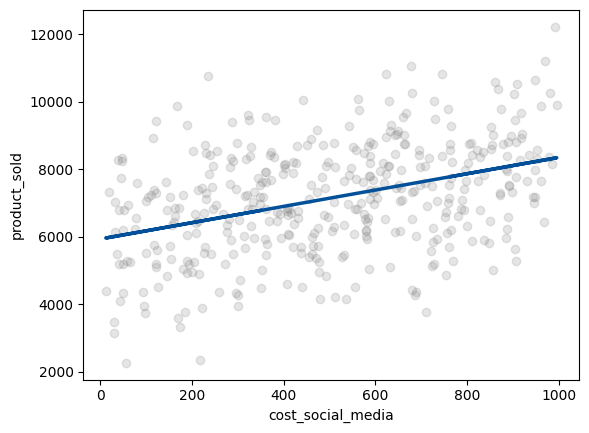

In [11]:
import matplotlib.pyplot as plt


def model_scipy(x):
    beta_0, beta_1 = betas_scipy
    return beta_0 + beta_1 * x


fix, ax = plt.subplots()
ax.scatter(cost_social_media, product_sold, color="grey", alpha=0.2)
ax.plot(
    cost_social_media,
    model_scipy(cost_social_media),
    color="#025099",
    linewidth=2.5,
    marker=None,
)

ax.set_xlabel("cost_social_media")
ax.set_ylabel("product_sold")

This visualization offers a clear representation of the fitted linear relationship and provides insights into the potential impact of social media advertising costs on product sales.

## sklearn

In this section, we explore an alternative approach to linear regression using the sklearn library.

Specifically, we employ the `LinearRegression` class to fit a linear model to our advertising data, relating social media advertising costs (`cost_social_media`) to product sales (`product_sold`).
Unlike the previous section, which utilized the `scipy.optimize.minimize` function for optimization, scikit-learn provides a streamlined interface for linear regression.
We'll use the `LinearRegression` class to handle the optimization process automatically and obtain optimal coefficients for our linear model.

### Reshaping arrays

The `LinearRegression` class in sklearn expects the input features (`X`) to be a 2D array for a couple of reasons related to its design and functionality:

-   The `LinearRegression` class is designed to handle multiple features simultaneously.
    When you provide a single feature, sklearn expects it to be represented as a 2D array with one column.
    This design allows the same class to seamlessly handle cases with multiple features, where each feature corresponds to a different column in the 2D array.
-   Sklearn follows a consistent API design, and many of its algorithms, including LinearRegression, are designed to work with 2D arrays or matrices as input features.
    This design choice simplifies the use of various sklearn tools and functionalities that are built around the assumption of 2D input arrays.

The `reshape(-1, 1)` operation converts a 1D array into a 2D array with a single column.

In [12]:
cost_social_media_sklearn = cost_social_media.reshape(-1, 1)
product_sold_sklearn = product_sold.reshape(-1, 1)

print("Old shape")
print(product_sold.shape)
print(product_sold[:10])

print("\nNew shape")
print(product_sold_sklearn.shape)
print(product_sold_sklearn[:10])

Old shape
(400,)
[7164. 5055. 6154. 5480. 9669. 7627. 5177. 3726. 9801. 8652.]

New shape
(400, 1)
[[7164.]
 [5055.]
 [6154.]
 [5480.]
 [9669.]
 [7627.]
 [5177.]
 [3726.]
 [9801.]
 [8652.]]


### Running

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
model = LinearRegression()

model.fit(X=cost_social_media_sklearn, y=product_sold_sklearn)
betas_sklearn = [model.intercept_[0], model.coef_[0][0]]

print(f"beta_0 = {betas_sklearn[0]:.3f}")
print(f"beta_1 =    {betas_sklearn[1]:.3f}")

beta_0 = 5932.473
beta_1 =    2.418


### Analysis


In [15]:
mse_sklearn = mse(betas_sklearn, cost_social_media, product_sold)
print(mse_sklearn)

2280263.4052002407


In [16]:
print(mse_sklearn - mse_scipy)

-5.9050507843494415e-06


Text(0, 0.5, 'product_sold')

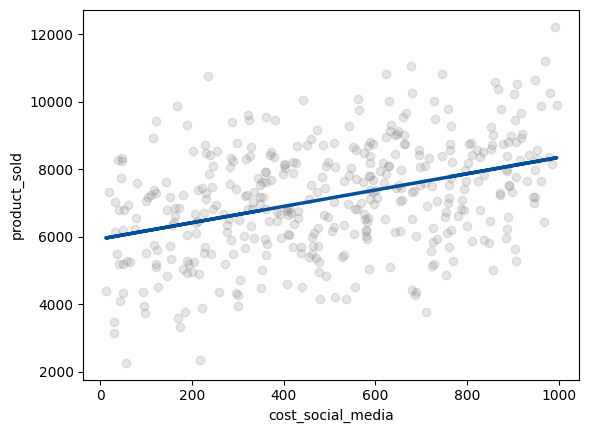

In [17]:
def model_sklearn(x, beta_0, beta_1):
    return beta_0 + beta_1 * x


fix, ax = plt.subplots()
ax.scatter(cost_social_media, product_sold, color="grey", alpha=0.2)
ax.plot(
    cost_social_media,
    model_sklearn(cost_social_media, betas_sklearn[0], betas_sklearn[1]),
    color="#025099",
    linewidth=2.5,
)

ax.set_xlabel("cost_social_media")
ax.set_ylabel("product_sold")

We can also visualize how the loss function changes with respect to the intercept and slope.
We create a range of parameters, compute the loss function, and then plot [contours](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.contourf.html#matplotlib.axes.Axes.contourf). 

In [18]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()

X = cost_social_media_sklearn
y = product_sold_sklearn

model.fit(X=X, y=y)

beta_0_values = np.linspace(model.intercept_[0] * 0.5, model.intercept_[0] * 1.5, 300)
beta_1_values = np.linspace(model.coef_[0][0] * 0.5, model.coef_[0][0] * 1.5, 300)

# Initialize arrays to store results
mse_values = np.zeros((len(beta_0_values), len(beta_1_values)))

# Loop through each combination of beta_0 and beta_1
for i, beta_0 in enumerate(beta_0_values):
    for j, beta_1 in enumerate(beta_1_values):
        # Fit the model
        model.intercept_ = np.array([beta_0])  # Set beta_0
        model.coef_ = np.array([[beta_1]])  # Set beta_1
        predictions = model.predict(X)

        # Calculate mean squared error
        mse_values[i, j] = mean_squared_error(y, predictions)

rmse_values = np.sqrt(mse_values)

beta_0_values, beta_1_values = np.meshgrid(beta_0_values, beta_1_values)

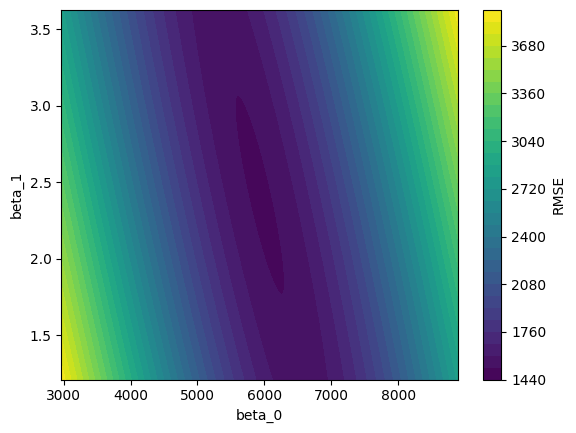

In [19]:
# Create filled contour plot
plt.contourf(beta_0_values, beta_1_values, rmse_values.T, levels=30, cmap="viridis")
plt.colorbar(label="RMSE")

plt.xlabel("beta_0")
plt.ylabel("beta_1")
plt.show()

## Acknowledgements

Much of this material has been adapted from [An Introduction to Statistical Learning](https://www.statlearning.com/) to be more digestible for undergraduates starting in Biology.